In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
import joblib
from utils import backtest
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore')

# List of columns where NaNs are allowed
allowed_nan_columns = [
    'TOTAL_LINE_MOVEMENT_3',
    'SPREAD_LINE_MOVEMENT_3',
    'SPREAD_LINE_MOVEMENT_1',
    'TOTAL_LINE_MOVEMENT_2',
    'SPREAD_LINE_MOVEMENT_2',
    'TOTAL_LINE_MOVEMENT_1',
    'HOME TEAM WIN%',
    'CREW',
    'FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team)',
    'HOME TEAM POINTS DIFFERENTIAL',
    'MAIN REF',
    'FOUL% AGAINST HOME TEAMS',
    'TOTAL POINTS PER GAME',
    'CALLED FOULS PER GAME',
    'FOUL% AGAINST ROAD TEAMS'
]

drop_cols = ['spread_result', 'ml_result', 'total_result', 'q3_result',
              'DATE', 'POSS', 'OEFF', 'DEFF', 'PACE', 'PTS',
                'Opp_Defensive_Rating', "Offensive_Rating", 
                "Defensive_Rating", 'Opp_Offensive_Rating', 'Elo_Var', 'Opp_Elo_Var']

DATA_ROOT = '../live_data'
MODEL_ROOT = '../models'

In [10]:

today = datetime.today().strftime('%Y-%m-%d')
yesterday = (datetime.today() - pd.Timedelta(days=3)).strftime('%Y-%m-%d')

df = pd.read_csv(f'{DATA_ROOT}/2024_2025_nba_team_full_{today}.csv')

# Dropping rows with NaN values, except in specified columns
#df = df.dropna(subset=[col for col in df.columns if col not in allowed_nan_columns])

# flip true and false in ml_result column
df['ml_result'] = df['ml_result'].apply(lambda x: True if x == False else False)

# convert categorical columns
df['MAIN REF'] = df['MAIN REF'].astype('category')
df['CREW'] = df['CREW'].astype('category')
df['TEAM_REST_DAYS'] = df['TEAM_REST_DAYS'].astype('category')
df['TEAM'] = df['TEAM'].astype('category')
df['Opponent'] = df['Opponent'].astype('category')

# convert venue to binary
df['VENUE'] = (df['VENUE'] == 'H')*1

# convert date to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

In [11]:
df = df.sort_values('DATE')
df = df.set_index('DATE')
# Rolling 14-day average of 'hit_over' (binary)
df['two_week_totals'] = (
    df['total_result']
    .rolling('14D')
    .mean()
    .shift(1)  # shift if you want strictly previous data
)

df['one_week_totals'] = (
    df['total_result']
    .rolling('7D')
    .mean()
    .shift(1)  # shift if you want strictly previous data
)
df.reset_index(inplace=True)
last_2_weeks = df[df['DATE'] > (df['DATE'].max() - pd.Timedelta(days=14))]
X_calibrate = last_2_weeks.drop(columns=['spread_result', 'ml_result',
                                          'total_result', 'q3_result', 'DATE',
                                            'POSS', 'OEFF', 'DEFF', 'PACE',
                                              'PTS', 'Momentum', 'GAME-ID'])


#df['DATE'] = df.index

X = df.drop(columns=['spread_result', 'ml_result', 'total_result', 'q3_result',
                      'DATE', 'POSS', 'OEFF', 'DEFF', 'PACE', 'PTS', 'Momentum', 'GAME-ID'])
y_ml = df['ml_result']
y_spread = df['spread_result']
y_q3 = df['q3_result']
y_total = df['total_result']
y_ml_calibrate = last_2_weeks['ml_result']
y_spread_calibrate = last_2_weeks['spread_result']  
y_q3_calibrate = last_2_weeks['q3_result']
y_total_calibrate = last_2_weeks['total_result']


X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X, y_ml, test_size=0.2, random_state=42)
X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(X_train_ml, y_train_ml, test_size=0.1, random_state=41)

X_train_spread, X_test_spread, y_train_spread, y_test_spread = train_test_split(X, y_spread, test_size=0.2, random_state=42)
X_train_spread, X_val_spread, y_train_spread, y_val_spread = train_test_split(X_train_spread, y_train_spread, test_size=0.1, random_state=41)

X_train_q3, X_test_q3, y_train_q3, y_test_q3 = train_test_split(X, y_q3, test_size=0.2, random_state=42)
X_train_q3, X_val_q3, y_train_q3, y_val_q3 = train_test_split(X_train_q3, y_train_q3, test_size=0.1, random_state=41)

X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X, y_total, test_size=0.2, random_state=42)
#X_train_total, X_val_total, y_train_total, y_val_total = train_test_split(X_train_total, y_train_total, test_size=0.1, random_state=41)

In [14]:
#spread_model = BootstrapCalibratedClassifier(n_bootstrap_samples=5)
#spread_model = joblib.load('calibrated_spread_model_2.pkl')

#ml_model = BootstrapCalibratedClassifier(n_bootstrap_samples=5)
#ml_model = joblib.load('calibrated_ml_model.pkl')

#total_model = BootstrapCalibratedClassifier(n_bootstrap_samples=5)
#total_model = joblib.load('calibrated_total_model_2.pkl')
total_model2 = joblib.load(f'{MODEL_ROOT}/calibrated_total_model_01_15_25_sig.pkl')

2025-01-19 00:00:00


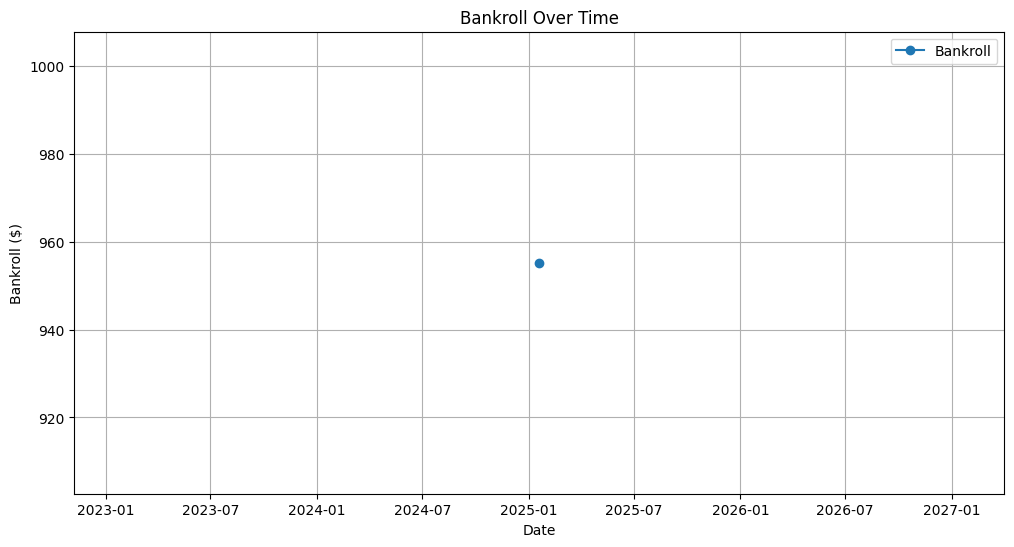

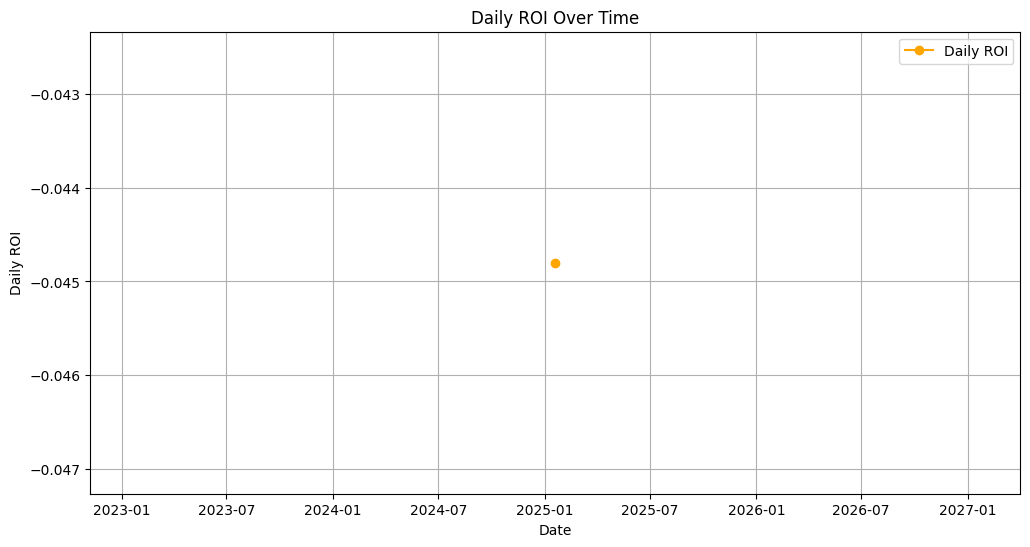

In [17]:
drop_cols = ['spread_result', 'ml_result', 'total_result', 'q3_result', 'Momentum',
              'DATE', 'POSS', 'OEFF', 'DEFF', 'PACE', 'PTS']

ifeatures = ['CREW',
 'TEAM',
 'Opponent',
 'MAIN REF',
 'CLOSING_TOTAL',
 'Win_Loss_Diff',
 'one_week_totals',
 'Opp_Momentum',
 'two_week_totals',
 'Opp_Elo_Var']

today = (datetime.now() - pd.DateOffset(1)).strftime('%Y-%m-%d')
# Example usage with defined constants
out = backtest.backtest_model(
    df=df,
    model=total_model2,
    feature_cols=ifeatures,  # Feature columns
    label_col='total_result',
    odds_col='CLOSING_TOTAL',
    start_date='2025-01-19',
    end_date=today,
    initial_bankroll=1000,
    bet_size=2, 
    kf=0.5
)
